# Imports

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
import heapq
import json
import time

from hdbscan import HDBSCAN
from joblib import Memory


# Load Data from storage

In [2]:
ground_truth_wall_path =  '../../Data/RTU-keywall-ground-truth-wall-subset.csv'
ground_truth_wall = np.loadtxt(ground_truth_wall_path, delimiter=',', dtype=np.float32)

ground_truth_floor_path =  '../../Data/RTU-keywall-ground-truth-floor-subset.csv'
ground_truth_floor = np.loadtxt(ground_truth_floor_path, delimiter=',', dtype=np.float32)

# Calculate silhouette score and noise classification accuaracy score for DBSCAN


## Define ε and MinPts arrays (DBSCAN)

In [16]:
# Define eps and min_samples vectors
count = 100
eps_start = 0.01
eps_end = 1
min_samples_start = 10
min_samples_end = 1000

eps_vals = np.linspace(eps_start, eps_end, num=count)
min_sample_vals = np.linspace(min_samples_start,min_samples_end,num=count)


## Test DBSCAN

In [17]:
# Perform DBSCAN and calculate Silhouette score and noise classification accuaracy

data = ground_truth_floor
eps = 0.5
minPts = 400
sample_size = 1000

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}] Initializing DBSCAN")
dbscan = DBSCAN(eps=eps, min_samples=minPts, n_jobs=-1)

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}] Performing DBSCAN")
dbscan.fit(data[ : , :3])

labels = dbscan.labels_

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}] Calculating cluster count")
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}] Calculating noise point count")
n_noise_ = list(labels).count(-1)

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}] Calculating Silhouette score")
silh_score = silhouette_score(ground_truth_floor, labels, sample_size=sample_size)

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}] Calculating accuaracy")
data_labels = data[: , 3]
data_noise_count = data_labels[data_labels == 255].shape[0]
data_correct_noise_point_count = np.count_nonzero((data_labels == 255) & (labels == -1))
data_incorrect_noise_point_count = np.count_nonzero((data_labels != 255) & (labels == -1))
acc = (data_correct_noise_point_count - data_incorrect_noise_point_count) / data_noise_count

curTime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"[{curTime}]")
print(f"\tEstimated number of clusters: {n_clusters_}")
print(f"\tEstimated number of noise points: {n_noise_}")
print(f"\tSilhouette Coefficient: {silh_score:.4f}")
print(f"\tAccuaracy: {acc:.4f}")

[26/05/2023 16:20:17] Initializing DBSCAN
[26/05/2023 16:20:17] Performing DBSCAN
[26/05/2023 16:20:21] Calculating cluster count
[26/05/2023 16:20:21] Calculating noise point count
[26/05/2023 16:20:21] Calculating Silhouette score
[26/05/2023 16:20:21] Calculating accuaracy
[26/05/2023 16:20:21]
	Estimated number of clusters: 4
	Estimated number of noise points: 209833
	Silhouette Coefficient: -0.0672
	Accuaracy: -0.5115


## Calculate Silhouette coefficients for Wall dataset

In [13]:
# Remove last column (classification) from data
Wall_raw = ground_truth_wall[: , :3]

# Ground truth noise point count
ground_truth_wall_labels = ground_truth_wall[: , 3]
ground_truth_wall_noise_count = ground_truth_wall_labels[ground_truth_wall_labels == 255].shape[0]

# File to log data
file = open("Wall_grid_search_sklearn.txt", 'w')

# Determine the size of output array:
size = eps_vals.shape[0]

# Iteratevely perform DBSCAN and calculate silhouette score
print("Calculating silhouette coefficients")
ith_iter = 0
for i, eps in enumerate(eps_vals, start=0):
    j = len(min_sample_vals) - 1
    for min_samples in min_sample_vals:
        ith_iter += 1
        # Initialize a new DBSCAN objcet and perform DBSCAN
        tmp_DB =  DBSCAN(eps=eps, min_samples=int(min_samples), n_jobs=-1)
        tmp_DB.fit(Wall_raw)

        # Info about DBSCAN results:
        cluster_count = len(set(tmp_DB.labels_)) - (1 if -1 in tmp_DB.labels_ else 0)
        noise_count = list(tmp_DB.labels_).count(-1)

        # Calculate silhouette score for sample_size points
        tmp_sil_coeff = 0
        status_str = ""
        try:
            tmp_sil_coeff = silhouette_score(Wall_raw, tmp_DB.labels_, sample_size=1000)
            status_str = f"{ith_iter}/{size*size}: Sucessfully calculated silhouette coefficient."
        except Exception as e:
            status_str = f"{ith_iter}/{size*size}: Couldn't calculate silhouette coefficient."

        # Calculate noise classification accuaracy
        correct_noise_point_count = np.count_nonzero((ground_truth_wall_labels == 255) & (tmp_DB.labels_ == -1))
        incorrect_noise_point_count = np.count_nonzero((ground_truth_wall_labels != 255) & (tmp_DB.labels_ == -1))
        tmp_acc = (correct_noise_point_count - incorrect_noise_point_count) / ground_truth_wall_noise_count

        status_str += f"\n\tCluster count: {cluster_count}"
        status_str += f"\n\tNoise point count: {noise_count}"
        status_str += f"\n\teps: {eps}, min samples: {min_samples}"
        status_str += f"\n\tSilhouette coefficient: {tmp_sil_coeff}"
        status_str += f"\n\tAcc: {tmp_acc}"
        status_str += "\n"

        print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        print(status_str)
        
        file.write(datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")
        file.write(status_str)

file.close()


Calculating silhouette coefficients
25/05/2023 23:55:34
1/10000: Sucessfully calculated silhouette coefficient.
	Cluster count: 201
	Noise point count: 92912
	eps: 0.01, min samples: 10.0
	Silhouette coefficient: -0.6052957773208618
	Acc: -0.04956547049773379

25/05/2023 23:55:35
2/10000: Sucessfully calculated silhouette coefficient.
	Cluster count: 7
	Noise point count: 95610
	eps: 0.01, min samples: 20.0
	Silhouette coefficient: -0.15506219863891602
	Acc: 0.006112520271113144

25/05/2023 23:55:36
3/10000: Couldn't calculate silhouette coefficient.
	Cluster count: 0
	Noise point count: 95756
	eps: 0.01, min samples: 30.0
	Silhouette coefficient: 0
	Acc: 0.009147989521393821

25/05/2023 23:55:37
4/10000: Couldn't calculate silhouette coefficient.
	Cluster count: 0
	Noise point count: 95756
	eps: 0.01, min samples: 40.0
	Silhouette coefficient: 0
	Acc: 0.009147989521393821

25/05/2023 23:55:38
5/10000: Couldn't calculate silhouette coefficient.
	Cluster count: 0
	Noise point count: 957

### Create a Silhouette score heatmap for Wall dataset

#### Parse results text file

Parse the output log and extract accuracy and silhouette scores

In [18]:
# Number of top items to find
n = 1

# Create 2D acc matrix
acc_wall = np.zeros((eps_vals.shape[0],min_sample_vals.shape[0]))
sil_wall = np.zeros((eps_vals.shape[0],min_sample_vals.shape[0]))

# Load log
log = open("Wall_grid_search_sklearn.txt", "r")
log_str = log.read()

# parse values
seperator = r'\d{2}/\d{2}/\d{4}\s\d{2}:\d{2}:\d{2}'
elems = re.split(seperator, log_str)
elems.pop(0) # First element is empty
elems.pop() # Last element also

i=99
j=0

# Map log to dict
log_data = {}
for elem in elems:
    iteration_number = int(re.search(r'(\d+/\d+):', elem).group(1).split("/").pop(0))
    cluster_count = int(re.search(r'Cluster count: (\d+)', elem).group(1))
    noise_point_count = int(re.search(r'Noise point count: (\d+)', elem).group(1))
    eps = float(re.search(r'eps: ([\d.]+)', elem).group(1))
    min_samples = int(re.search(r'min samples: (\d+)', elem).group(1))
    silhouette_coefficient = float(re.search(r'Silhouette coefficient: (-?\d+\.\d+|0)', elem).group(1))
    acc= float(re.search(r'Acc: (-?\d+\.\d+|0)', elem).group(1))


    log_data[iteration_number] = {
        "cluster_count": cluster_count,
        "noise_point_count": noise_point_count,
        "eps": eps,
        "min_samples": min_samples,
        "silhouette_coefficient": silhouette_coefficient,
        "acc": acc
    }
    acc_wall[i,j] = acc
    sil_wall[i,j] = silhouette_coefficient
    i -= 1
    if i == -1:
        i=99
        j+=1

# Use heapq.nlargest to get the n items with the highest silhouette coefficient
top_n_sil = heapq.nlargest(n, log_data.items(), key=lambda x: x[1]["silhouette_coefficient"])
top_n_acc = heapq.nlargest(n, log_data.items(), key=lambda x: x[1]["acc"])

# Print the top n Acc
print(f"\n============================\n|| Top {n} accuracy scores ||\n============================")
for item in top_n_acc:
    print(json.dumps(item, indent=4))

# Print the top n sil
print(f"\n==============================\n|| Top {n} silhouette scores ||\n==============================")
for item in top_n_sil:
    print(json.dumps(item, indent=4))

# Print the top n sil
print(f"\n==============================\n|| Top {n} silhouette scores ||\n==============================")
for item in top_n_sil:
    print(json.dumps(item, indent=4))



|| Top 1 accuracy scores ||
[
    9364,
    {
        "cluster_count": 2,
        "noise_point_count": 6472,
        "eps": 0.9400000000000001,
        "min_samples": 640,
        "silhouette_coefficient": -0.01675638183951378,
        "acc": 0.08536737494282506
    }
]

|| Top 1 silhouette scores ||
[
    8300,
    {
        "cluster_count": 3,
        "noise_point_count": 41187,
        "eps": 0.8300000000000001,
        "min_samples": 1000,
        "silhouette_coefficient": 0.4583919644355774,
        "acc": -0.5314358185371533
    }
]


#### Create heatmaps

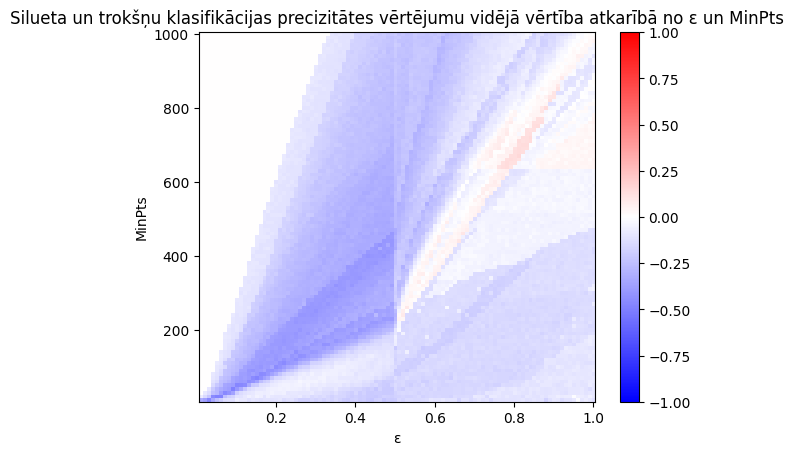

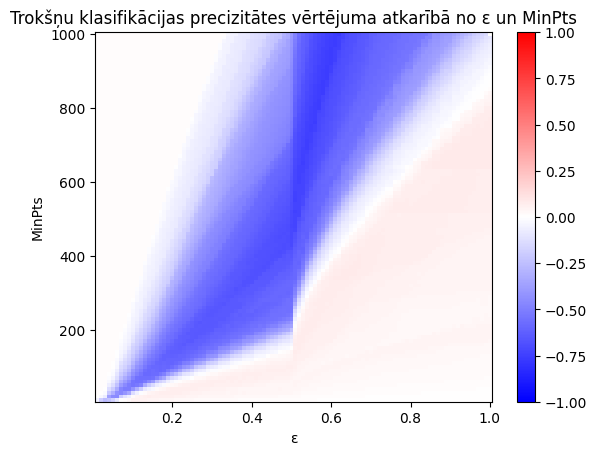

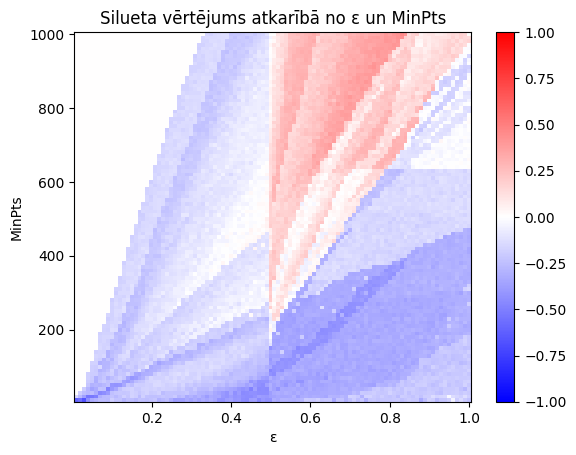

In [19]:
# Sum of acc + sil score
plt.figure(0)

d_eps = eps_vals[1] - eps_vals[0]
d_ms = min_sample_vals[1] - min_sample_vals[0]
im = plt.imshow(((sil_wall+acc_wall)/2), extent=[eps_vals.min() - d_eps/2, eps_vals.max() + d_eps/2, min_sample_vals.min() - d_ms/2, min_sample_vals.max() + d_ms/2],
        cmap='bwr', vmin=-1, vmax=1, aspect='auto')

# Set colorbar 
plt.colorbar(im)

# Add labels
plt.xlabel('ε')
plt.ylabel('MinPts')
plt.title('Silueta un trokšņu klasifikācijas precizitātes vērtējumu vidējā vērtība atkarībā no ε un MinPts')
plt.savefig("Wall_DBSCAN_grid_search_heat_map_acc_sil.svg", format="svg", dpi=1200)

# Acc=======================================================
plt.figure(1)

d_eps = eps_vals[1] - eps_vals[0]
d_ms = min_sample_vals[1] - min_sample_vals[0]
im = plt.imshow((acc_wall), extent=[eps_vals.min() - d_eps/2, eps_vals.max() + d_eps/2, min_sample_vals.min() - d_ms/2, min_sample_vals.max() + d_ms/2],
        cmap='bwr', vmin=-1, vmax=1, aspect='auto')

# Set colorbar 
plt.colorbar(im)

# Add labels
plt.xlabel('ε')
plt.ylabel('MinPts')
plt.title('Trokšņu klasifikācijas precizitātes vērtējuma atkarībā no ε un MinPts')
plt.savefig("Wall_DBSCAN_grid_search_heat_map_acc.svg", format="svg", dpi=1200)

# Sil======================================================
plt.figure(2)

d_eps = eps_vals[1] - eps_vals[0]
d_ms = min_sample_vals[1] - min_sample_vals[0]
im = plt.imshow((sil_wall), extent=[eps_vals.min() - d_eps/2, eps_vals.max() + d_eps/2, min_sample_vals.min() - d_ms/2, min_sample_vals.max() + d_ms/2],
        cmap='bwr', vmin=-1, vmax=1, aspect='auto')

# Set colorbar 
plt.colorbar(im)

# Add labels
plt.xlabel('ε')
plt.ylabel('MinPts')
plt.title('Silueta vērtējums atkarībā no ε un MinPts')
plt.savefig("Wall_DBSCAN_grid_search_heat_map_sil.svg", format="svg", dpi=1200)

#### Test multiple <i>sample_size</i> values for same ε and MinPts

In the heatmaps above it can be seen that color changes rapidly thus indicating possible error in calculations. Therefore silhouette score is calculated for multiple sample sizes to observe difference

In [20]:
data = ground_truth_floor[: , :3]

sample_sizes = np.arange(start=0, stop=55000, step=5000)
sample_sizes[0] = 1000

# Create DBSCAN object

dbscan = DBSCAN(eps=0.5, min_samples=400, n_jobs=-1)
dbscan.fit(data)
labels = dbscan.labels_

for i in range(3):
    print("==================================")
    print(f"{i+1}. iteraton")
    print("==================================")
    for sample_size in sample_sizes:
        # Calculate silhouette score
        t1= time.time()
        try:
            silh_score = silhouette_score(data, labels, sample_size=sample_size)
        except:
            silh_score = 0
        print(f"Sample size : silhouette Coefficient: {sample_size}:{silh_score:.4f} Time taken: {(time.time()-t1):.4f}")

1. iteraton
Sample size : silhouette Coefficient: 1000:-0.1813 Time taken: 0.0440
Sample size : silhouette Coefficient: 5000:-0.1890 Time taken: 0.5820
Sample size : silhouette Coefficient: 10000:-0.1972 Time taken: 2.4700
Sample size : silhouette Coefficient: 15000:-0.1966 Time taken: 4.7100
Sample size : silhouette Coefficient: 20000:-0.1978 Time taken: 8.4680
Sample size : silhouette Coefficient: 25000:-0.1978 Time taken: 12.9180
Sample size : silhouette Coefficient: 30000:-0.1932 Time taken: 18.4900
Sample size : silhouette Coefficient: 35000:-0.1950 Time taken: 24.2140
Sample size : silhouette Coefficient: 40000:-0.1933 Time taken: 30.9850
Sample size : silhouette Coefficient: 45000:-0.1962 Time taken: 38.7200
Sample size : silhouette Coefficient: 50000:-0.1968 Time taken: 48.7700
2. iteraton
Sample size : silhouette Coefficient: 1000:-0.1849 Time taken: 0.0460
Sample size : silhouette Coefficient: 5000:-0.1890 Time taken: 0.5880
Sample size : silhouette Coefficient: 10000:-0.1943